# Walmart Recruiting - Store Sales Forecasting -  Step 3: Xgboost

For various reasons, I also tend to quickly genereate a second basic baseline using a tree-based model (xgboost, lightgbm or catboost). They allow me to quickly plot the feature importance therefore I can focus more effort accordingly.

They handle null value and outliers so scaling numerical data is not necessarly. The only think I will have to
do is to convert the categorical features into numeric. I will be using label encoding.


### Take away of the notebook
    . build ML pipeline to generate submission
    . Initial feagture engineering
    . Label encoding
    . Feature importance
    . Model evaluation
    . The baseline is not that great to our common-sense baseline and thera is some room for improvements

In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# loading data

In [3]:
df_train = pd.read_parquet('data/train.parquet')
df_test = pd.read_parquet('data/test.parquet')

target = 'Weekly_Sales'
df_train.shape, df_test.shape

((421570, 16), (115064, 16))

In [4]:
df_train.head()

,Date,Dept,IsHoliday,Store,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,2010-02-05,1,False,1,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,2010-02-12,1,True,1,46039.49,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,2010-02-19,1,False,1,41595.55,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,2010-02-26,1,False,1,19403.54,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,2010-03-05,1,False,1,21827.90,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


# Data pre-processing

#### Date engineering

In [8]:
# combine train/test
traintest = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# new features
traintest["Year"] = traintest.Date.dt.year
traintest["Month"] = traintest.Date.dt.month
traintest["Week"] = traintest.Date.dt.week
traintest["Day"] = traintest.Date.dt.day
traintest["day_of_year"] = traintest.Date.dt.dayofyear
traintest["days_in_month"] = traintest.Date.dt.days_in_month

# given store/dept/week extract the weekly sales from last year
traintest["Prev_Y"] = (traintest.Date - timedelta(days=365)).dt.year
traintest["Prev_Y_W"] = (traintest.Date - timedelta(days=365)).dt.week
# traintest["Prev_Year_Plus_1wk"] = (traintest.Prev_Year - timedelta(weeks=1)).dt.week
# traintest["Prev_Year_Plus_2wk"] = (traintest.Prev_Year - timedelta(weeks=2).dt.week
# traintest["Prev_Year_Minus_1wk"] = (traintest.Prev_Year + timedelta(weeks=1).dt.week
# traintest["Prev_Year_Minus_2wk"] = (traintest.Prev_Year + timedelta(weeks=2).dt.week


previous_year = traintest[['Store', 'Dept', 'Year', 'Week', 'Weekly_Sales']].copy()
previous_year.rename(columns={'Year': 'Prev_Y', 'Week': 'Prev_Y_W',
                              'Weekly_Sales': 'Prev_Year_Weekly_Sales'}, inplace=True)
traintest = traintest.merge(previous_year, how='left', on=['Store', 'Dept', 'Prev_Y', 'Prev_Y_W'])
traintest = traintest[traintest.columns.drop(['Prev_Y', 'Prev_Y_W'])]
traintest.Prev_Year_Weekly_Sales.fillna(0, inplace=True)

# convert to category
traintest['Store'] = traintest.Store.astype('category')
traintest['Dept'] = traintest.Dept.astype('category')
traintest['Size'] = traintest.Size.astype('category')
traintest['Type'] = traintest.Type.astype('category')

# map bool IsHoliday to 0/1 values
traintest['IsHoliday'] = traintest.IsHoliday.map({False: 0, True: 1})

# get only year difference with 2013
# traintest["Year"] = 2013 - traintest.Year


# traintest['MarkDown1'] = traintest.MarkDown1.fillna(-99)
# traintest['MarkDown2'] = traintest.MarkDown2.fillna(-99)
# traintest['MarkDown3'] = traintest.MarkDown3.fillna(-99)
# traintest['MarkDown4'] = traintest.MarkDown4.fillna(-99)
# traintest['MarkDown5'] = traintest.MarkDown5.fillna(-99)
# traintest['CPI'] = traintest.CPI.fillna(-99)
# traintest['Unemployment'] = traintest.Unemployment.fillna(-99)

# define numerical and categorical features
cats = ['object', 'bool', 'category']
nums = ['int64', 'float64']
cat_features = traintest.select_dtypes(include=cats).columns.tolist()
num_features = traintest.select_dtypes(include=nums).columns.drop(target).tolist()
cat_features, num_features

(['Dept', 'Store', 'Type', 'Size'],
 ['IsHoliday',
  'Temperature',
  'Fuel_Price',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment',
  'Year',
  'Month',
  'Week',
  'Day',
  'day_of_year',
  'days_in_month',
  'Prev_Year_Weekly_Sales'])

#### saving datasets

In [9]:
# save train set
df = traintest[:len(df_train)].reset_index(drop=True)
df.to_parquet('data/train_extended.parquet', compression='brotli')

# save test set
df = traintest[len(df_train):].reset_index(drop=True)
df.to_parquet('data/test_extended.parquet', compression='brotli')
print('done')

done


#### Label encoding

In [175]:
def label_encoding_by_sales(df, features_to_encode):
    data = pd.DataFrame(index=df.index)
    if isinstance(features_to_encode, str): 
        features_to_encode = [features_to_encode]
    # label encoding by sales rank
    for col in features_to_encode:
        sales_rank = (df[:len(df_train)].groupby(col)
                        .Weekly_Sales
                        .sum().rank()
                        .astype(np.int16))
        data[col] = df[col].map(sales_rank)

    return data

# encode cat features
traintest[cat_features] = label_encoding_by_sales(traintest, cat_features)
traintest.info()

## Baseline using XGBoost

#### helper functions

In [429]:
def rmse(y_true, y_pred):
    result = np.sum((y_true-y_pred)**2) / len(y_true)
    return result**0.5

def plot_history(history, offset=None):
    results = history.evals_result()
    if offset is not None:
        rmse_train = results['validation_0']['rmse'][offset:]
        rmse_test = results['validation_1']['rmse'][offset:]
        x_axis = range(offset, len(rmse_train)+offset)
    else:
        rmse_train = results['validation_0']['rmse']
        rmse_test = results['validation_1']['rmse']
        x_axis = range(0, len(rmse_train))

    # plot rmse
    fig, ax = plt.subplots()
    ax.plot(x_axis, rmse_train, label='Train')
    ax.plot(x_axis, rmse_test, label='Val')
    ax.legend()
    plt.ylabel('rmse')
    plt.title('XGBoost rmse')
    plt.show()

#### train/val/test, time-based split

In [390]:
# features to pass to xgboost
feat_cols = num_features+cat_features

# construct train/test datasets
train = traintest[:len(df_train)]
test = traintest[len(df_train):]

# define train sets, time-based split (2011-11-11: first week where Markdown exist)
# mask=(train.Date>='2011-11-11 00:00:00') & (train.Date<'2012-01-01 00:00:00')
mask=(train.Date>='2011-11-11 00:00:00') & (train.Date<'2012-08-17 00:00:00')
X_train = train.loc[mask, feat_cols]
y_train = train.loc[mask, target]

# get valid data from week of 2012-01-01 until week of 2012-10-26 (43 weeks)
# mask=(train.Date>='2012-01-01 00:00:00')
mask=(train.Date>='2012-08-17 00:00:00')
X_val = train.loc[mask, feat_cols]
y_val = train.loc[mask, target]

#### Build  model

In [421]:
xgb = XGBRegressor(n_estimators=1000, max_depth=6, learning_rate=0.15,
                    colsample_bytree=0.9, subsample=0.6,
                    nthread=-1, seed=0)

eval_set = [(X_train, y_train.ravel()), (X_val, y_val.ravel())]

# fit model
history = xgb.fit(X=X_train,
                    y=y_train.ravel(),
                    eval_metric=['rmse', 'error'],
                    eval_set=eval_set,
                    early_stopping_rounds=80,
                    verbose=False)

# evaluate predictions
val_preds = xgb.predict(X_val)
print('rmse: {}'.format(rmse(y_val, val_preds)))

rmse: 3201.265362798634


#### plot RMSE train/val as per number of iteration and feature importance

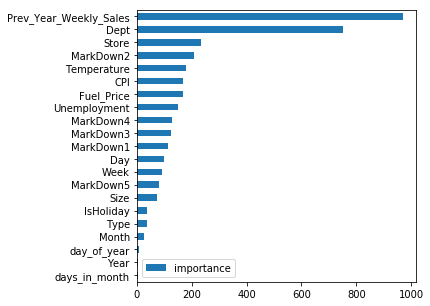

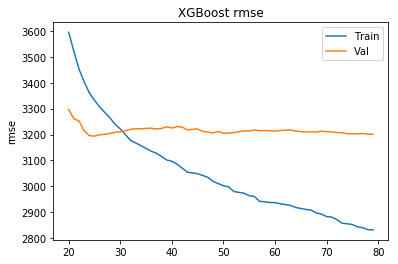

In [430]:
df = pd.DataFrame([xgb.booster().get_score(importance_type='weight')]).T
df.columns = ['importance']
df = df.sort_values('importance')
df.plot.barh(figsize=(5,5));

# plot history
plot_history(history, 20)

### re-train model on full train set + bagging + create submission file

In [415]:
bags=10
bagged_predictions = np.zeros(X_test.shape[0])

for i in range(bags):
    seed=i+100
    print('processing bag: #{}...'.format(i))
    xgb = XGBRegressor(n_estimators=30, max_depth=6, learning_rate=0.15,
                        colsample_bytree=0.9, subsample=0.6,
                        nthread=-1, seed=seed)

    # fit model
    xgb.fit(X=train[feat_cols],
                    y=train[target].ravel(),
                    verbose=False)

    preds = xgb.predict(test[feat_cols])
    bagged_predictions += preds

# averaging the preds
bagged_predictions /= bags

# create submission file
submission = df_test.copy()
submission[target] = bagged_predictions
submission['Id'] = (submission.Store.astype(str)+'_'+
               submission.Dept.astype(str)+'_'+
                submission.Date.astype(str))
cols = ['Id', 'Weekly_Sales']
submission[cols].to_csv('data/submission-xgb-6.csv', index=False, header=True)
print('done')

processing bag: #0...
processing bag: #1...
processing bag: #2...
processing bag: #3...
processing bag: #4...
processing bag: #5...
processing bag: #6...
processing bag: #7...
processing bag: #8...
processing bag: #9...
done


#### Note:
xgboost baseline: rank #252<br>
public lb: 3298.22197<br>
private lb: 3177.72273<br>

The common-sense baseline is still the winner: rank #150<br>
public lb: 3025.89776<br>
private lb: 2943.93191<br>

#### a few considerations<br>
    - predict the log of weekly sales and see if there are improvements
    . using stacking with other type of models (lightgm, catboost, extratrees, SVM)
    . more data engineering including week lags from previous year
    . try deep learning with entity embeddings
    . try deep learning sequence model for the time series problem using sequence of weeks 